In [410]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [411]:
# Import Data
assets = ['ZECUSDT', 'XMRUSDT']
data = {}
prices = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices[asset]['log_price'] = prices[asset]['price'].apply(lambda x: math.log(x))
    prices[asset]['returns'] = prices[asset]['price'].pct_change().fillna(0)
    prices[asset]['log_returns'] = prices[asset]['log_price'].pct_change().fillna(0)
    

## Utilities Functions

In [412]:
def set_same_length(df1, df2):
    # Set data same length
    if len(df1) > len(df2):
        diff = len(df1) - len(df2)
        df1 = df1[diff:]
    elif len(df1) < len(df2):
        diff = len(df2) - len(df1)
        df2 = df2[diff:]
    else:
        pass
    
    return df1, df2

def rolling_zscore(series, window):
    mean = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()

    return (series - mean) / std


## Calculate Spread & Z-Score

In [413]:
rolling_window = 24 * 14
prices[assets[0]], prices[assets[1]] = set_same_length(prices[assets[0]], prices[assets[1]])

# Spread
price_spread = prices[assets[0]]['price'].reset_index()['price']/prices[assets[1]]['price'].reset_index()['price']
log_price_spread = prices[assets[0]]['log_price'].reset_index()['log_price']/prices[assets[1]]['log_price'].reset_index()['log_price']
spread = pd.DataFrame({'date': prices[assets[0]]['date'], 'price': list(price_spread)})
log_spread = pd.DataFrame({'date': prices[assets[0]]['date'], 'price': list(price_spread)})

# Z-Score
zscore = rolling_zscore(log_spread['price'], rolling_window)


## Define Strategy

In [519]:
def get_backtest_performance(price_a, price_b, positions, fees, starting_capital, order_size_pct, beta):
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    
     # Calculate Fees
    trades = 0
    current_pos = 0
    for i in positions:
        if i != current_pos:
            trades += 1
            current_pos = i
            
    fees_paid = 1 - (1-fees)**trades
    
    # Calculate strategy return
    long_leg_returns = pd.Series(list(returns_a)) * pd.Series(positions) # Returns of first leg
    short_leg_returns = pd.Series(list(returns_b)) * pd.Series(positions) * -1 #Returns of second leg (must inverse positions first)

    long_leg_cumsum = long_leg_returns.cumsum().apply(np.exp)
    short_leg_cumsum = short_leg_returns.cumsum().apply(np.exp)

    long_leg_dollar_size = starting_capital * order_size_pct / 2 * beta
    short_leg_dollar_size = starting_capital * order_size_pct - long_leg_dollar_size
    
    long_leg_dollar_returns = long_leg_dollar_size * list(long_leg_cumsum)[len(long_leg_cumsum)-1]
    short_leg_dollar_returns = short_leg_dollar_size * list(short_leg_cumsum)[len(short_leg_cumsum)-1]
    
    capital = long_leg_dollar_size * long_leg_cumsum + short_leg_dollar_size * short_leg_cumsum

    return capital, fees_paid

## Returns backtesting stats from strategy
# price_a: series
# prices_b: series
# window: rolling window for zscore
# std_multiple: nbr of standard deviation where we want to trigger trades
# trading_fee: fee in %
# capital: starting capital in $
# order_size_pct: % of capital to use at each trade
# beta: price_b is the dependant variable (Y), so Y = beta * X. We multiply beta with dollar size for price_a
def zscore_mean_reversion_strategy(price_a, price_b, window, std_multiple, trading_fee, starting_capital, order_size_pct, beta):
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    positions = [0,0]
    
    spread = price_a / price_b
    zscore = list(rolling_zscore(spread, window).fillna(0))
    
    # Get Trades
    for i in range(2, len(zscore)):
        # If short and zscore goes at or under 0, close short
        if positions[i-1] == -1 and zscore[i-1] <= 0:
            positions.append(0)
        # If long and zscore goes at or above 0, close long
        elif positions[i-1] == 1 and zscore[i-1] >= 0:
            positions.append(0)
        # If zscore goes above std and comes back under, short signal
        elif positions[i-1] == 0 and zscore[i-2] > std_multiple and zscore[i-1] < std_multiple:
            positions.append(-1)
        # If zscore goes under std and comes back over, long signal
        elif positions[i-1] == 0 and zscore[i-2] < -std_multiple and zscore[i-1] > -std_multiple:
            positions.append(1)
        # Else, keep same position
        else:
            positions.append(positions[i-1])
    
    capital, fees_paid = get_backtest_performance(price_a, price_b, positions, trading_fee, starting_capital, order_size_pct, beta)

    return positions, capital, fees_paid, zscore


def rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    df = df.reset_index()
    close_delta = df['price'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
        # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods).mean()
        ma_down = down.rolling(window = periods).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi


def rsi_mean_reversion_strategy(price_a, price_b, window, signals, trading_fee, starting_capital, order_size_pct, beta):
    
    longEntry = signals[0]
    longClose = signals[1]
    shortEntry = signals[2]
    shortClose = signals[3]
    
    returns_a = price_a.pct_change().fillna(0)
    returns_b = price_b.pct_change().fillna(0)
    spread = price_a / price_b
    positions = [0, 0]
    
    spread_rsi = rsi(spread, window, False)
    
    # Get Trades
    for i in range(2, len(spread_rsi)):
        # If rsi goes above shortEntry and comes back under, short signal
        if spread_rsi[i-2] >= shortEntry and spread_rsi[i-1] < shortEntry:
            positions.append(-1)
        # If rsi goes under longEntry and comes back over, long signal
        elif spread_rsi[i-2] <= longEntry and spread_rsi[i-1] > longEntry:
            positions.append(1)
        # If in short position and rsi hits shortClose
        elif positions[i-1] == -1 and spread_rsi[i-1] <= shortClose:
            positions.append(0)
        # If in long position and rsi hits longClose
        elif positions[i-1] == 1 and spread_rsi[i-1] >= longClose:
            positions.append(0)
        # Else, keep same position
        else:
            positions.append(positions[i-1])
    
    capital, fees_paid = get_backtest_performance(price_a, price_b, positions, trading_fee, starting_capital, order_size_pct, beta)

    return positions, capital, fees_paid, spread_rsi
    
    
    

In [492]:
tr = 0
ps = 0
for i in positions:
    if i != ps:
        tr += 1
        ps = i
tr

15

In [580]:
'{:.2f}%'.format(capital.std()/capital[0]*100)

'9.68%'

## Backtest Strategy

Returns: 21.92%
Fees paid: 3.19%


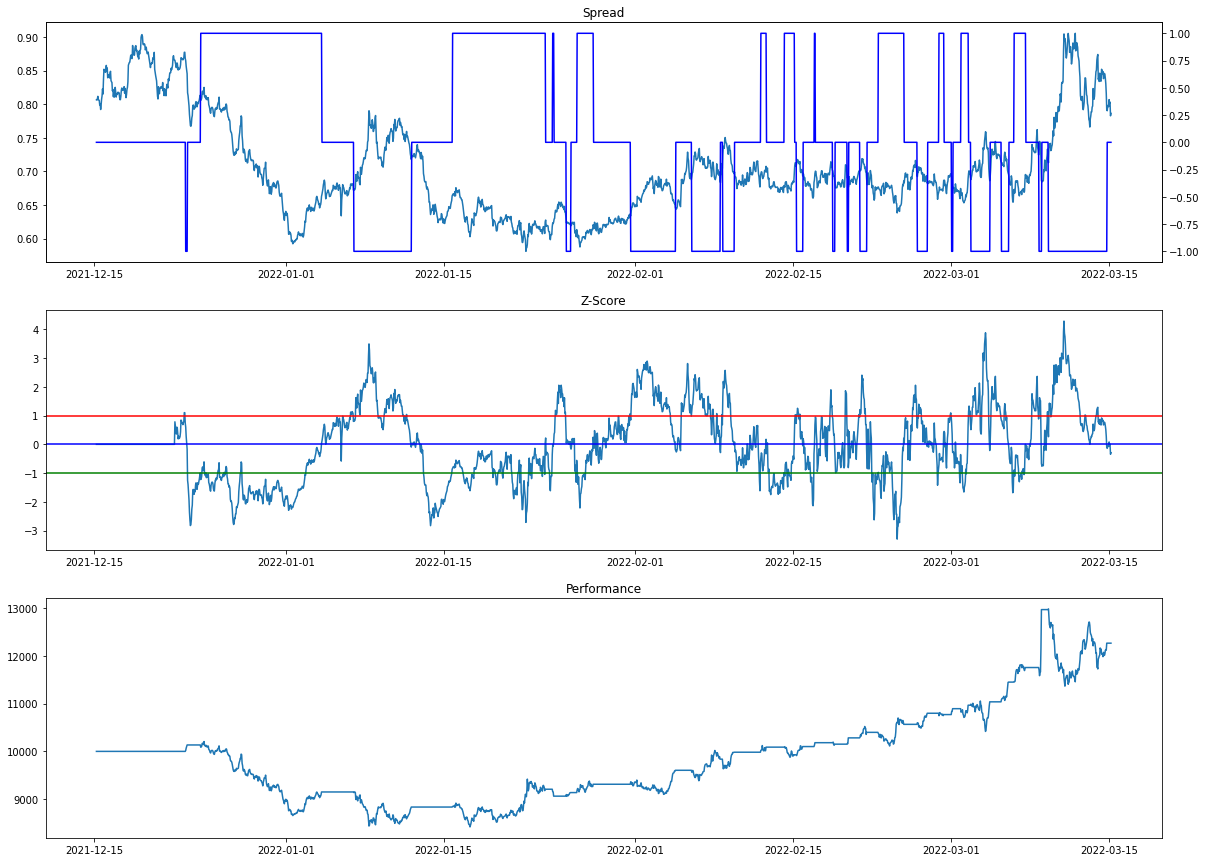

In [570]:
start_date = len(prices[assets[0]]) - 24 * 30 * 3
end_date = len(prices[assets[0]]) - 24 * 0
price1 = prices[assets[0]]['price'].reset_index()['price'][start_date:end_date]
price2 = prices[assets[1]]['price'].reset_index()['price'][start_date:end_date]
dates = prices[assets[0]]['date'][start_date:end_date]
fees = 0.0006
rolling_window = 24*7
std_multiple = 1
start_capital = 10000.0
order_size_pct = 1
beta = 1
positions, capital, fees_paid, zscore = zscore_mean_reversion_strategy(price1, price2, rolling_window, std_multiple, fees, start_capital, order_size_pct, beta)

# Visualization
fig, axs = plt.subplots(3, figsize=(20,15))
fig.figsize=(20,15)
axs[0].plot(dates, price1/price2)
axs[0].title.set_text('Spread')
axs0_2 = axs[0].twinx()
axs0_2.plot(dates, positions, color='b')
axs[1].plot(dates, zscore)
axs[1].title.set_text('Z-Score')
axs[1].axhline(std_multiple, color='r')
axs[1].axhline(-std_multiple, color='g')
axs[1].axhline(0, color='b')
axs[2].plot(dates, capital)
axs[2].title.set_text('Performance')

print('Returns: {:.2f}%'.format((list(capital)[-1]/list(capital)[0]-1)*100*(1-fees_paid)))
print('Fees paid: {:.2f}%'.format(fees_paid*100))

In [461]:
# RSI
start_date = len(prices[assets[0]]) - 24 * 30 * 1
end_date = len(prices[assets[0]]) - 24 * 0
price1 = prices[assets[0]]['price'].reset_index()['price'][start_date:end_date]
price2 = prices[assets[1]]['price'].reset_index()['price'][start_date:end_date]
dates = prices[assets[0]]['date'][start_date:end_date]
fees = 0.0006
rsi_window = 14
# long, closelong, short, closeshort rsis
signals = [30, 50, 70, 50]
start_capital = 10000.0
order_size_pct = 1
beta = 1
positions, capital, fees_paid, rsi_data = rsi_mean_reversion_strategy(price1, price2, rsi_window, signals, fees, start_capital, order_size_pct, beta)

# Visualization
fig, axs = plt.subplots(3, figsize=(20,15))
fig.figsize=(20,15)
axs[0].plot(dates, price1/price2)
axs[0].title.set_text('Spread')
axs0_2 = axs[0].twinx()
axs0_2.plot(dates, positions, color='b')
axs[1].plot(dates, rsi_data)
axs[1].title.set_text('RSI')
axs[1].axhline(signals[2], color='r')
axs[1].axhline(signals[0], color='g')
axs[1].axhline(0, color='b')
axs[2].plot(dates, capital)
axs[2].title.set_text('Performance')

print('Returns: {:.2f}%'.format((list(capital)[-1]/list(capital)[0]-1)*100-(1-fees_paid)))
print('Fees paid: {:.2f}%'.format(fees_paid*100))

ValueError: not enough values to unpack (expected 4, got 3)

## Compare lookback periods and STD multiples

[Text(0.5, 24.0, 'Lookback Window'), Text(879.0, 0.5, 'STD Multiples')]

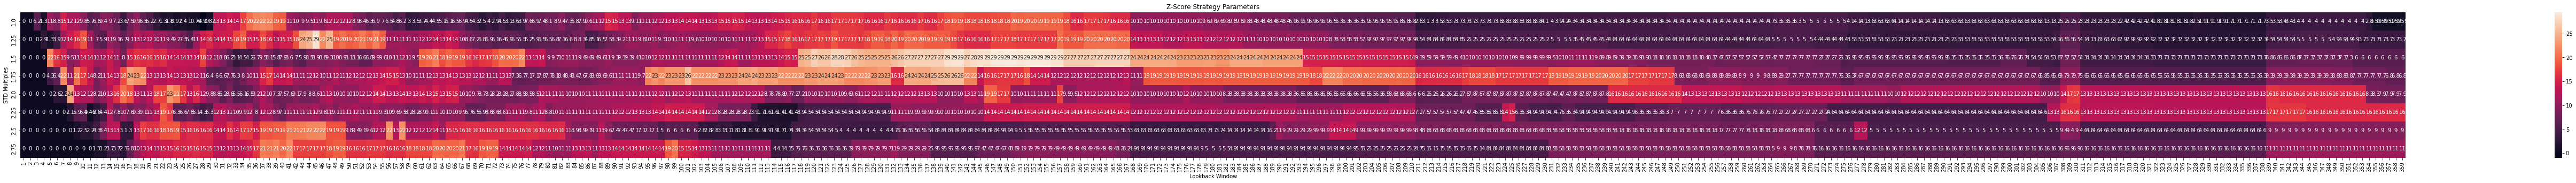

In [561]:
start_date = len(prices[assets[0]]) - 24 * 30 * 1
end_date = len(prices[assets[0]]) - 24 * 0
price1 = prices[assets[0]]['price'].reset_index()['price'][start_date:end_date]
price2 = prices[assets[1]]['price'].reset_index()['price'][start_date:end_date]
dates = prices[assets[0]]['date'][start_date:end_date]
fees = 0.0006
start_capital = 10000.0
order_size_pct = 1
beta = 1

lookback_windows = range(1, 24*15)
std_multiples = [1.0,1.25,1.5,1.75,2.0,2.25,2.50,2.75]
returns_matrix = pd.DataFrame(index=std_multiples, columns=lookback_windows)

for lb in lookback_windows:
    for std in std_multiples:
        positions, capital, fees_paid, zscore = zscore_mean_reversion_strategy(price1, price2, lb, std, fees, start_capital, order_size_pct, beta)
        returns = (list(capital)[-1]/list(capital)[0]-1)*100*(1-fees_paid)
        returns_matrix[lb][std] = returns
        
plt.figure(figsize=(100,5))
plt.title('Z-Score Strategy Parameters')
hm = sb.heatmap(returns_matrix.astype(float), annot=True)
hm.set(xlabel='Lookback Window', ylabel='STD Multiples')
        

## Median values

In [563]:
best_lb_window = 0
best_lb_window_return = 0
best_std_multiple = 0
best_std_multiple_return = 0

for lb in lookback_windows:
    lb_median_return = returns_matrix[:][lb].median()
    if lb_median_return > best_lb_window_return:
        best_lb_window_return = lb_median_return
        best_lb_window = lb
        
for i in range(0,len(std_multiples)):
    std_multiple_median_return = returns_matrix.iloc[i].median()
    if std_multiple_median_return > best_std_multiple_return:
        best_std_multiple_return = std_multiple_median_return
        best_std_multiple = returns_matrix.index[i]

print('Best lookback window: {} and best std multiple: {}'.format(best_lb_window, best_std_multiple))

Best lookback window: 147 and best std multiple: 1.75
